In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import time

C:\Users\xiang\AppData\Local\Temp\ipykernel_26380\156397289.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
file_path = "../datasets/train_set3.csv"
df = pd.read_csv(file_path)
EMPTYCONST = "*empty*"

# Concatenate relevant text features
catFamily = (
    df["Family"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*family*" if x != EMPTYCONST else x)
)
catSubFamily = (
    df["SubFamily"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*subfamily*" if x != EMPTYCONST else x)
)
catObjectGroup = (
    df["ObjectGroup"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*objectgroup*" if x != EMPTYCONST else x)
)
catObjectName = (
    df["ObjectName"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*objectname*" if x != EMPTYCONST else x)
)
# catAssemblyCode = df["Assembly Code"].fillna(EMPTYCONST)
# catAssemblyDescription = df["Assembly Description"].fillna(EMPTYCONST)
catDescription = (
    df["Description"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*description*" if x != EMPTYCONST else x)
)
catTypeComments = (
    df["Type Comments"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*typecomments*" if x != EMPTYCONST else x)
)
# catTypeName = df["Type Name"].fillna(EMPTYCONST)
catStructuralMaterial = (
    df["Structural Material"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*structuralmaterial*" if x != EMPTYCONST else x)
)
catMaterial = (
    df["Material"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*material*" if x != EMPTYCONST else x)
)


df["Features"] = (
    catFamily
    + "|"
    + catSubFamily
    + "|"
    + catObjectGroup
    + "|"
    + catObjectName
    + "|"
    # + catAssemblyCode
    # + "|"
    # + catAssemblyDescription
    # + "|"
    + catDescription
    + "|"
    + catTypeComments
    + "|"
    # + catTypeName
    # + "|"
    + catStructuralMaterial
    + "|"
    + catMaterial
)

# Split data into features (X) and target variable (y)
X = df["Features"].fillna(EMPTYCONST)
y = df["Category"]

WEIGHT_FAMILY = 10
WEIGHT_SUBFAMILY = 4
WEIGHT_OBJECTNAME = 6
WEIGHT_STRUCTURALMATERIAL = 2
WEIGHT_MATERIAL = 2
WEIGHT_DESCRIPTION = 2


# Custom tokenizer function with variable weights for different categories
def custom_tokenizer(text):
    # Tokenize the text
    tokens = text.split("|")

    # Assign weights to tokens based on hyperparameters
    weighted_tokens = []
    for token in tokens:
        if "_*family*" in token:
            weighted_tokens.extend([token] * WEIGHT_FAMILY)
        elif "_*subfamily*" in token:
            weighted_tokens.extend([token] * WEIGHT_SUBFAMILY)
        elif "_*objectname*" in token:
            weighted_tokens.extend([token] * WEIGHT_OBJECTNAME)
        elif "_*description*" in token:
            weighted_tokens.extend([token] * WEIGHT_DESCRIPTION)
        elif "_*structuralmaterial*" in token:
            weighted_tokens.extend([token] * WEIGHT_STRUCTURALMATERIAL)
        elif "_*material*" in token:
            weighted_tokens.extend([token] * WEIGHT_MATERIAL)
        elif token == EMPTYCONST:
            weighted_tokens.extend([token] * 0)  # Assigning a 0 weight for 'empty'
        else:
            weighted_tokens.append(token)

    return weighted_tokens

# Start timing
start_time = time.time()

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
X_tfidf = vectorizer.fit_transform(X)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier()
# Define hyperparameters grid for tuning
# param_grid = {
#     "n_estimators": [50, 100, 200],
#     "max_depth": [None, 10, 20],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "random_state": [0, 42, 123],
# } 
# Define hyperparameters grid for tuning
param_grid = {
    "n_estimators": [200],
    "max_depth": [None],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "random_state": [42],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3)
grid_search.fit(X_tfidf, y)

# Get the best estimator from grid search
best_estimator = grid_search.best_estimator_

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_estimator, X_tfidf, y, cv=kf, scoring='accuracy')

# Print cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# End timing
end_time = time.time()

# Calculate total runtime
total_time = end_time - start_time
print(f"Total runtime: {total_time} seconds")

# Save the trained model to a file
model_filename = "rf_tfidf_best.pkl"
joblib.dump(best_estimator, model_filename)

# Evaluate the model with the best parameters found
# Split data into training and testing sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Make predictions on the test set
predictions = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy on test set:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, predictions))

c:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Cross-validation scores: [0.90800681 0.92504259 0.93526405 0.91822828 0.92662116]
Mean cross-validation score: 0.9226325796117238
Total runtime: 41.62773609161377 seconds
Accuracy on test set: 1.0

Classification Report:
                                                    precision    recall  f1-score   support

                         Adjustable Louvred Window       1.00      1.00      1.00         9
                              Architectural Column       1.00      1.00      1.00       107
                                         Brickwall       1.00      1.00      1.00         2
                              Cast In-Situ RC Wall       1.00      1.00      1.00         6
                                  Compartment Wall       1.00      1.00      1.00         2
                                      Curtain Wall       1.00      1.00      1.00        58
                                          Dry Wall       1.00      1.00      1.00         4
                     Fire Alarm Fixture an

Accuracy: 0.00819672131147541

Classification Report:
                                                    precision    recall  f1-score   support

                         Adjustable Louvred Window       0.00      0.00      0.00         1
                              Architectural Column       0.01      1.00      0.02         1
                              Cast In-Situ RC Wall       0.00      0.00      0.00        22
                                      Curtain Wall       0.00      0.00      0.00        14
                     Fire Alarm Fixture and Device       0.00      0.00      0.00        10
                              Fixed Louvred Window       0.00      0.00      0.00         1
                                Fixed Panel Window       0.00      0.00      0.00         5
                                      Floor Finish       0.00      0.00      0.00         9
General Door Item (including Gate, Roller Shutter)       0.00      0.00      0.00        21
                         

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


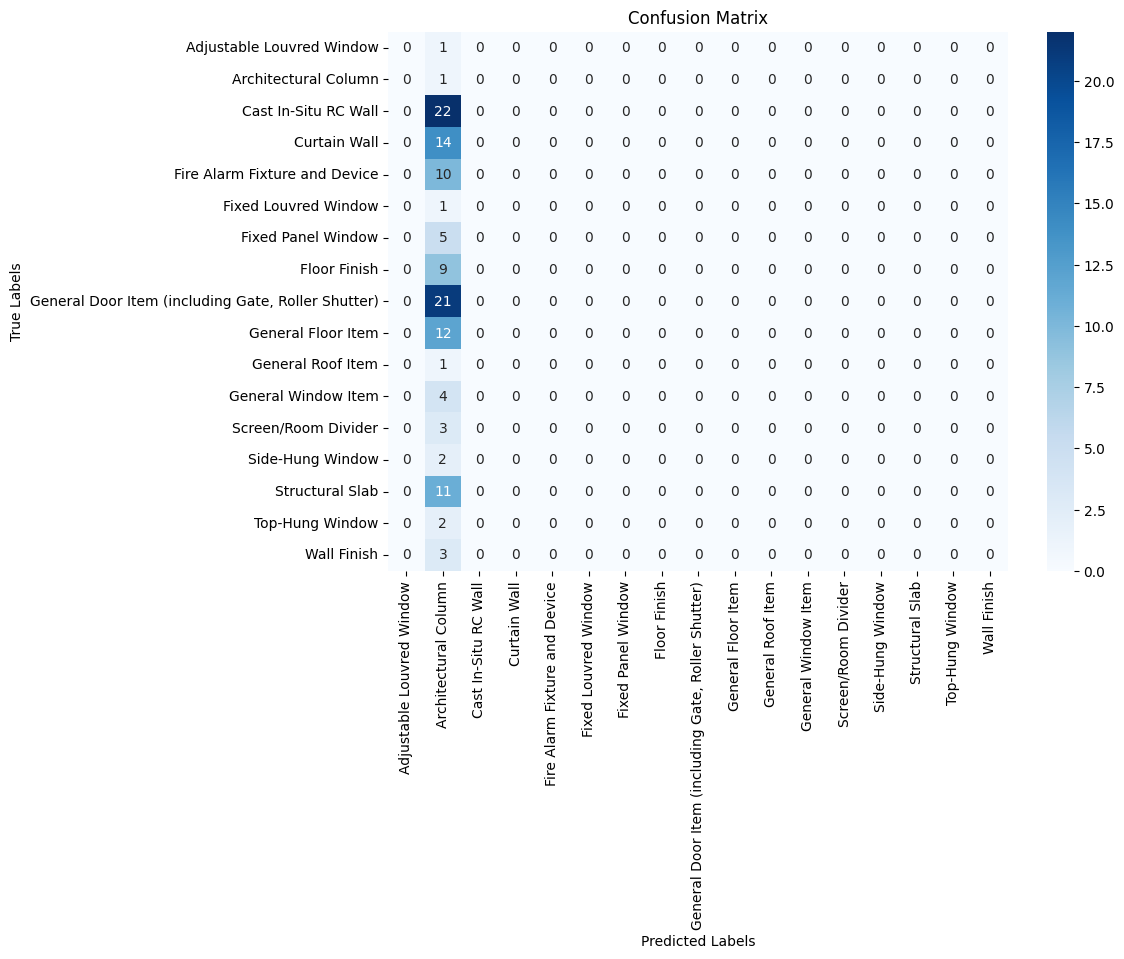

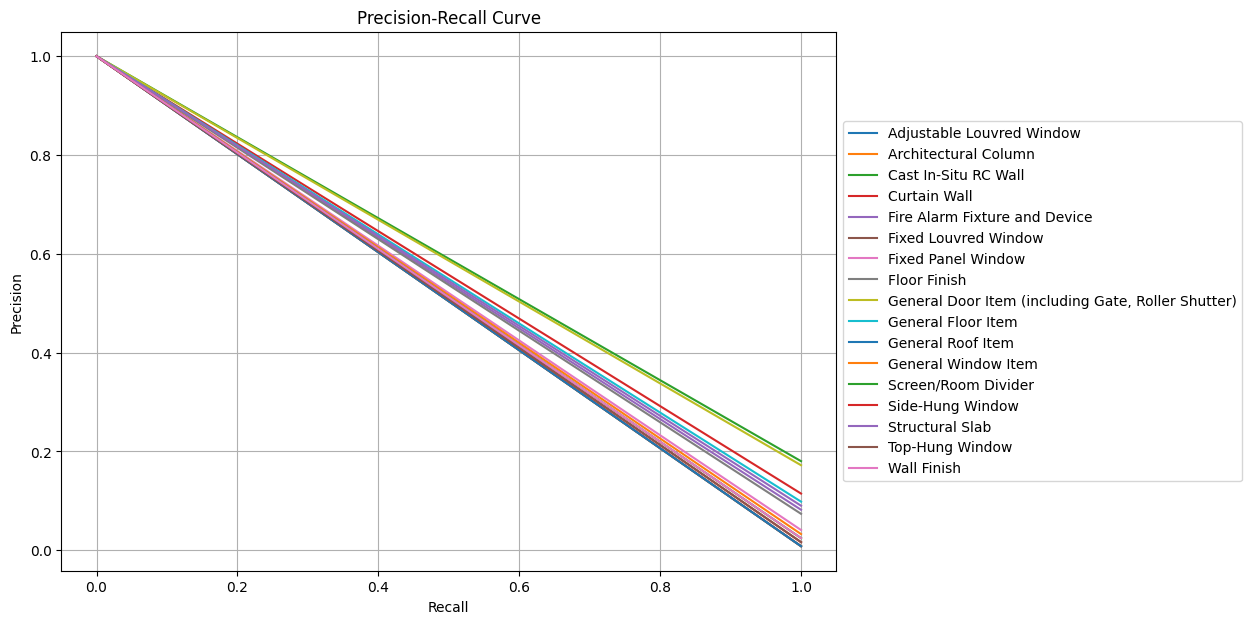

In [3]:
rf_classifier = joblib.load(model_filename)

# Load new data (example: assume `new_data.csv` has the same structure as `train_set.csv`)
new_data_file = "../datasets/test_set.csv"
new_df = pd.read_csv(new_data_file)

EMPTYCONST = "*empty*"

# Concatenate relevant text features
catFamily = (
    new_df["Family"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*family*" if x != EMPTYCONST else x)
)
catSubFamily = (
    new_df["SubFamily"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*subfamily*" if x != EMPTYCONST else x)
)
catObjectGroup = (
    new_df["ObjectGroup"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*objectgroup*" if x != EMPTYCONST else x)
)
catObjectName = (
    new_df["ObjectName"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*objectname*" if x != EMPTYCONST else x)
)
# catAssemblyCode = df["Assembly Code"].fillna(EMPTYCONST)
# catAssemblyDescription = df["Assembly Description"].fillna(EMPTYCONST)
catDescription = (
    new_df["Description"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*description*" if x != EMPTYCONST else x)
)
catTypeComments = (
    new_df["Type Comments"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*typecomments*" if x != EMPTYCONST else x)
)
# catTypeName = df["Type Name"].fillna(EMPTYCONST)
catStructuralMaterial = (
    new_df["Structural Material"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*structuralmaterial*" if x != EMPTYCONST else x)
)
catMaterial = (
    new_df["Material"]
    .fillna(EMPTYCONST)
    .apply(lambda x: x + "_*material*" if x != EMPTYCONST else x)
)


new_df["Features"] = (
    catFamily
    + "|"
    + catSubFamily
    + "|"
    + catObjectGroup
    + "|"
    + catObjectName
    + "|"
    # + catAssemblyCode
    # + "|"
    # + catAssemblyDescription
    # + "|"
    + catDescription
    + "|"
    + catTypeComments
    + "|"
    # + catTypeName
    # + "|"
    + catStructuralMaterial
    + "|"
    + catMaterial
)

# Split data into features (X) and target variable (y)
X = df["Features"].fillna(EMPTYCONST)
y = df["Category"]

WEIGHT_FAMILY = 10
WEIGHT_SUBFAMILY = 4
WEIGHT_OBJECTNAME = 6
WEIGHT_STRUCTURALMATERIAL = 2
WEIGHT_MATERIAL = 2
WEIGHT_DESCRIPTION = 2


# Custom tokenizer function with variable weights for different categories
def custom_tokenizer(text):
    # Tokenize the text
    tokens = text.split("|")

    # Assign weights to tokens based on hyperparameters
    weighted_tokens = []
    for token in tokens:
        if "_*family*" in token:
            weighted_tokens.extend([token] * WEIGHT_FAMILY)
        elif "_*subfamily*" in token:
            weighted_tokens.extend([token] * WEIGHT_SUBFAMILY)
        elif "_*objectname*" in token:
            weighted_tokens.extend([token] * WEIGHT_OBJECTNAME)
        elif "_*description*" in token:
            weighted_tokens.extend([token] * WEIGHT_DESCRIPTION)
        elif "_*structuralmaterial*" in token:
            weighted_tokens.extend([token] * WEIGHT_STRUCTURALMATERIAL)
        elif "_*material*" in token:
            weighted_tokens.extend([token] * WEIGHT_MATERIAL)
        elif token == EMPTYCONST:
            weighted_tokens.extend([token] * 0)  # Assigning a 0 weight for 'empty'
        else:
            weighted_tokens.append(token)

    return weighted_tokens

# Vectorize text data using the same CountVectorizer instance
X_new_tfidf = vectorizer.transform(new_df["Features"])

# Predict using the loaded model
predictions_new = rf_classifier.predict(X_new_tfidf)

# Calculate accuracy
accuracy = accuracy_score(new_df["Category"], predictions_new)
print(f"Accuracy: {accuracy}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(new_df["Category"], predictions_new)

# Display classification report
print("\nClassification Report:")
class_report = classification_report(new_df["Category"], predictions_new)
print(class_report)

category_names = []
lines = class_report.splitlines()
for line in lines[2:-4]:  # Skip header and footer lines
    category_name = line.strip().split("       ")[0]
    category_names.append(category_name)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=category_names,
    yticklabels=category_names,  # Use the model's class labels
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Compute precision and recall for each class
precision = dict()
recall = dict()
thresholds = dict()

# Assuming predictions_new and new_df["Category"] are already defined

# Compute precision-recall curve for each class
for i, category_name in enumerate(category_names):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(
        (new_df["Category"] == category_name).astype(int),
        rf_classifier.predict_proba(X_new_tfidf)[:, i],
    )

# Plot recall curve
plt.figure(figsize=(10, 7))
for i, category_name in enumerate(category_names):
    plt.plot(recall[i], precision[i], label=f"{category_name}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Place legend to the right
plt.grid(True)
plt.show()